In [3]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# Step 1: Generate synthetic data
np.random.seed(42)
X = np.random.rand(1000, 10)  # 1000 samples, 10 features
y = (X.sum(axis=1) > 5).astype(int)  # Binary target based on feature sum

# Step 2: Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Further split the training data for attack setup
X_train_model, X_shadow, y_train_model, y_shadow = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Step 3: Train a target model
target_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

target_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
target_model.fit(X_train_model, y_train_model, epochs=10, batch_size=32, verbose=0)

# Step 4: Collect confidence scores from the target model
train_confidences = target_model.predict(X_train_model).flatten()  # Confidence scores for training data
test_confidences = target_model.predict(X_test).flatten()          # Confidence scores for test data

# Label the data for the attack model (1 for members, 0 for non-members)
attack_X = np.concatenate([train_confidences, test_confidences])
attack_y = np.concatenate([np.ones(len(train_confidences)), np.zeros(len(test_confidences))])

# Step 5: Train an attack model to classify members vs. non-members
attack_model = LogisticRegression()
attack_model.fit(attack_X.reshape(-1, 1), attack_y)

# Step 6: Evaluate the attack model
attack_predictions = attack_model.predict_proba(attack_X.reshape(-1, 1))[:, 1]
auc_score = roc_auc_score(attack_y, attack_predictions)

print(f"Membership Inference Attack AUC: {auc_score:.4f}")

# Test on a new dataset to validate the attack
shadow_confidences = target_model.predict(X_shadow).flatten()
shadow_labels = np.ones(len(shadow_confidences))  # Assume shadow data are members for testing

# Predict membership
shadow_predictions = attack_model.predict_proba(shadow_confidences.reshape(-1, 1))[:, 1]
shadow_auc = roc_auc_score(shadow_labels, shadow_predictions)

print(f"Shadow Dataset Attack AUC: {shadow_auc:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
Membership Inference Attack AUC: 0.5416
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [1]:
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 67.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 93.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [ ]:
from ctgan import CTGAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load your dataset
original_data = pd.read_csv('diabetic_data.csv')

# Preprocessing
data = original_data.drop(columns=["encounter_id", "patient_nbr"])
categorical_columns = data.select_dtypes(include=["object"]).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    data[col] = label_encoders[col].fit_transform(data[col])

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Train CTGAN
ctgan = CTGAN(epochs=50)  # You can increase the epochs for better results
ctgan.fit(train_data, discrete_columns=list(categorical_columns))

# Generate synthetic data
synthetic_data = ctgan.sample(len(test_data))

# Membership Inference Attack
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Create labels for membership: 1 for training data, 0 for synthetic
train_data["membership"] = 1
synthetic_data["membership"] = 0

# Combine and shuffle
combined_data = pd.concat([train_data, synthetic_data]).sample(frac=1, random_state=42)
X = combined_data.drop(columns=["membership"])
y = combined_data["membership"]

# Split for attack model
X_train, X_attack, y_train, y_attack = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a simple attack model
attack_model = RandomForestClassifier(random_state=42)
attack_model.fit(X_train, y_train)

# Evaluate the attack
y_pred = attack_model.predict(X_attack)
attack_results = {
    "accuracy": accuracy_score(y_attack, y_pred),
    "precision": precision_score(y_attack, y_pred),
    "recall": recall_score(y_attack, y_pred)
}

print("Attack Results:", attack_results)

Attack Results: {'accuracy': 0.9291516541107108, 'precision': 0.9244813595651841, 'recall': 0.9921948814854373}


In [6]:
synthetic_data.to_csv('synthetic_data.csv', index=False)

In [7]:
synthetic_data.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,membership
0,3,0,7,1,3,3,1,9,8,19,...,3,1,0,0,0,0,0,1,1,0
1,1,1,8,1,1,18,4,9,11,19,...,2,1,0,0,0,0,1,1,2,0
2,3,1,7,8,1,3,7,7,0,10,...,3,1,0,0,0,0,1,1,2,0
3,3,1,7,1,1,28,7,1,8,28,...,3,1,0,0,0,0,1,0,1,0
4,3,0,6,1,1,21,17,6,0,63,...,1,1,0,0,0,0,1,1,0,0


In [8]:
synthetic_data.shape

(20354, 49)

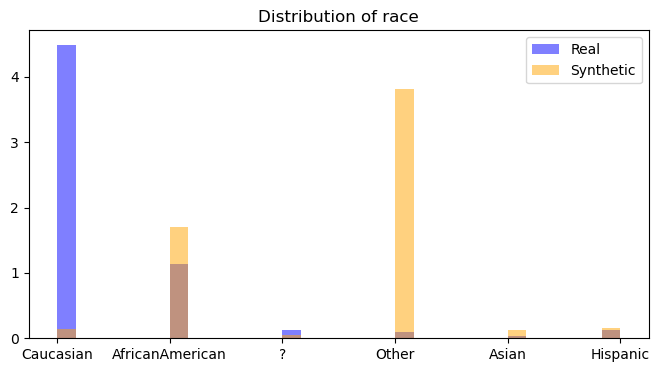

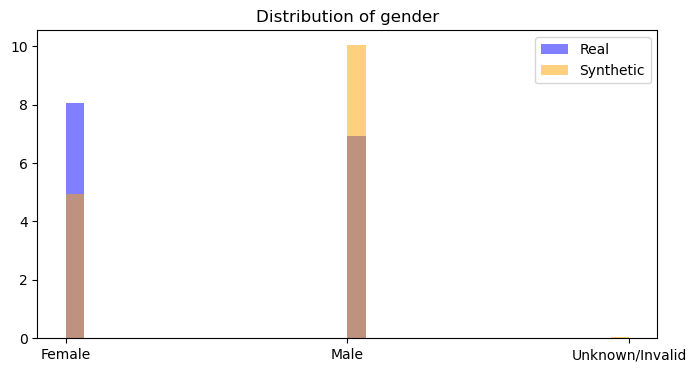

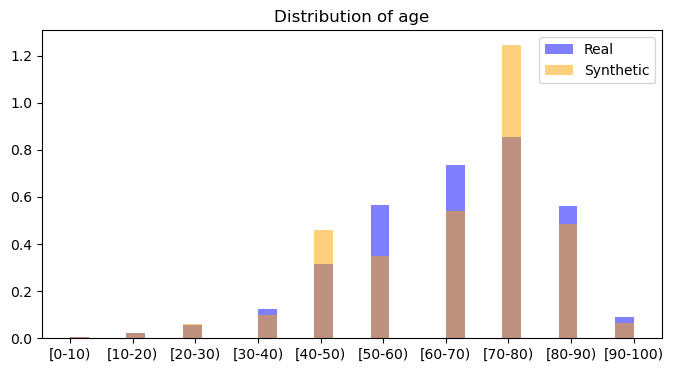

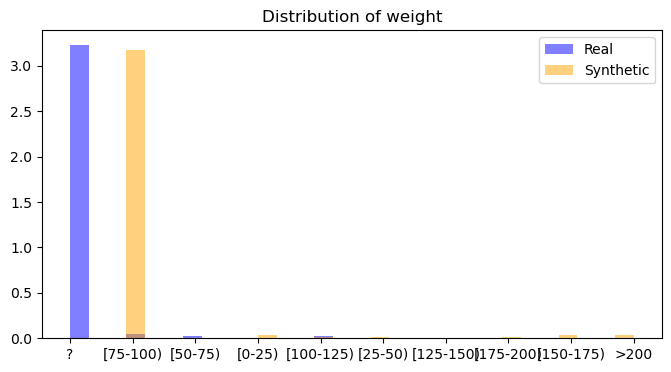

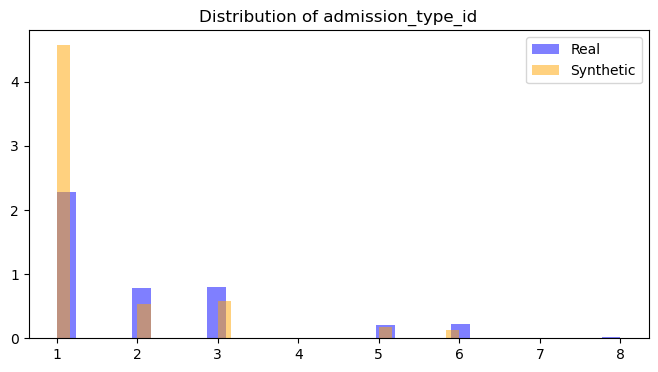

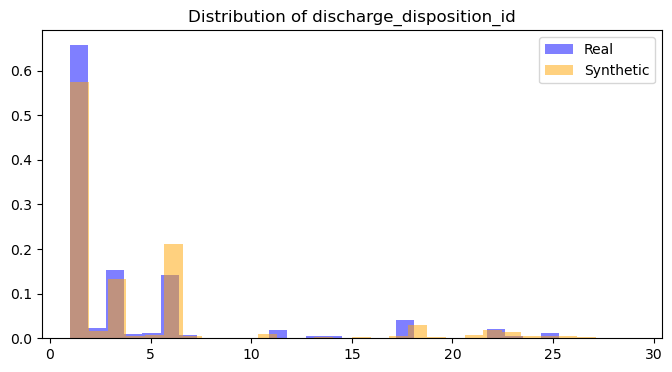

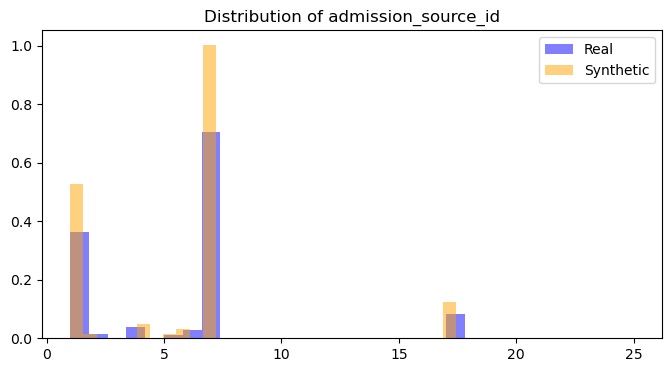

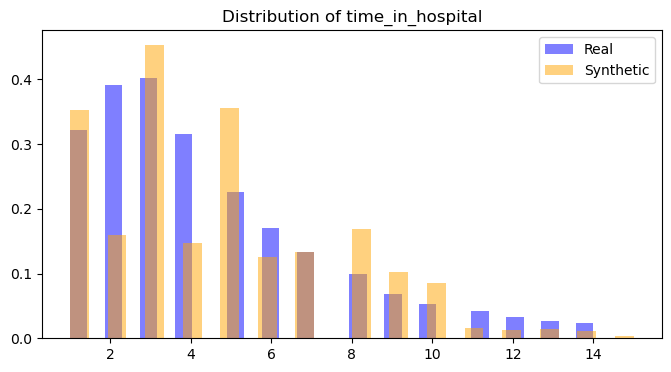

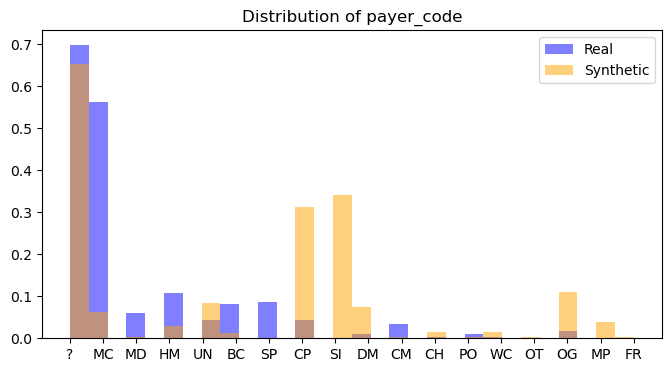

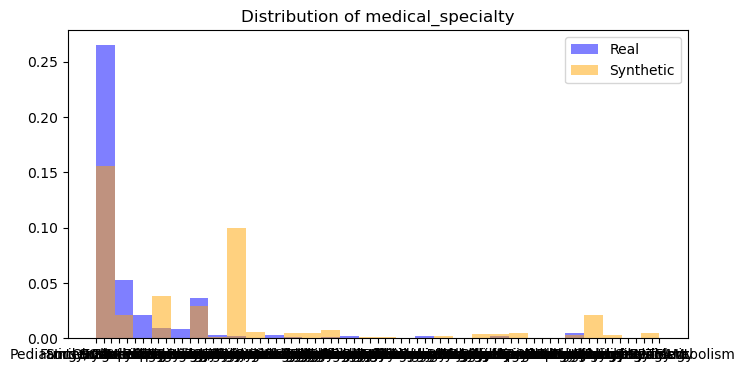

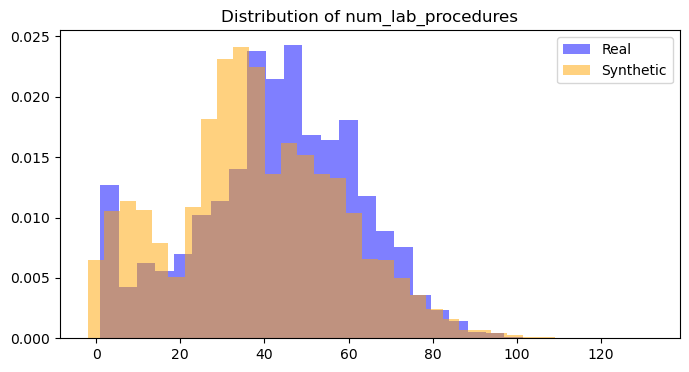

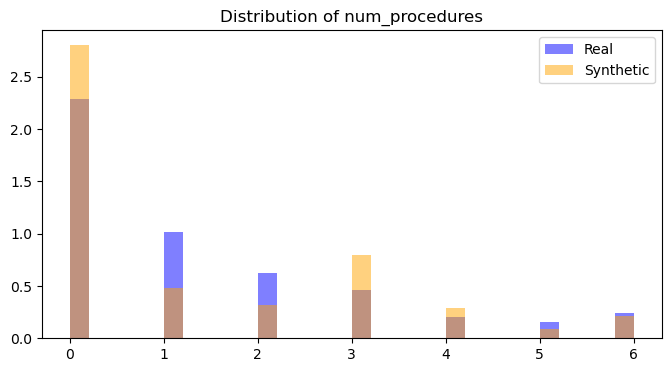

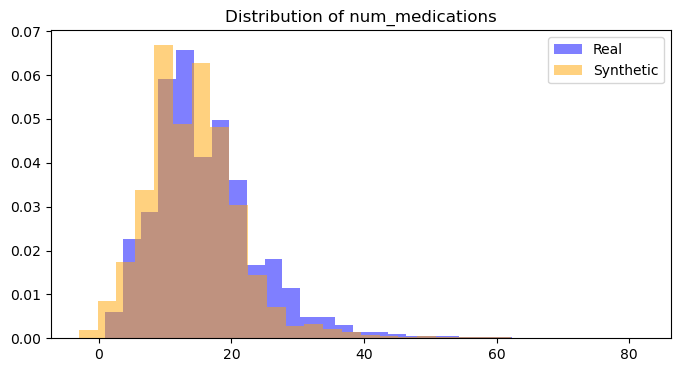

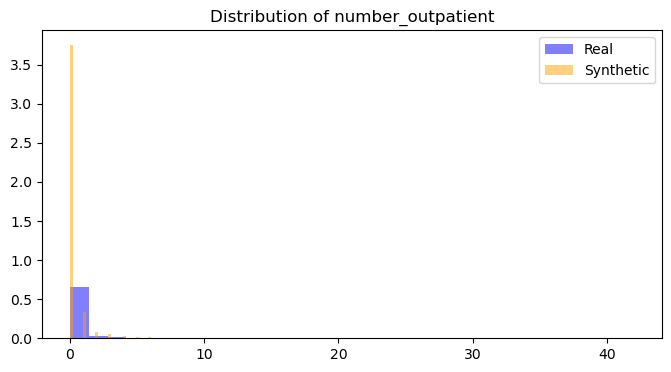

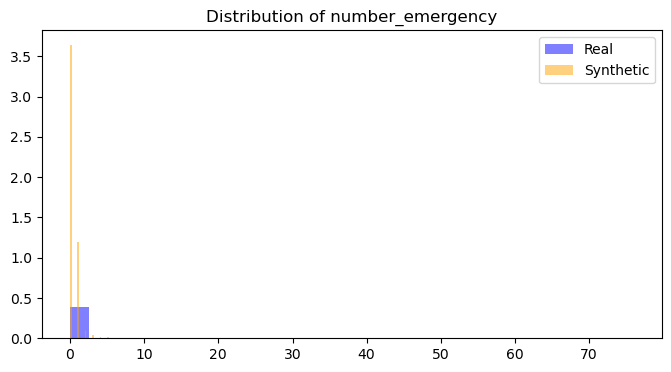

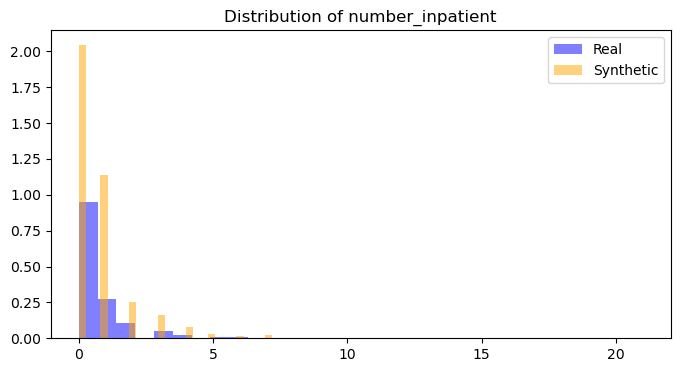

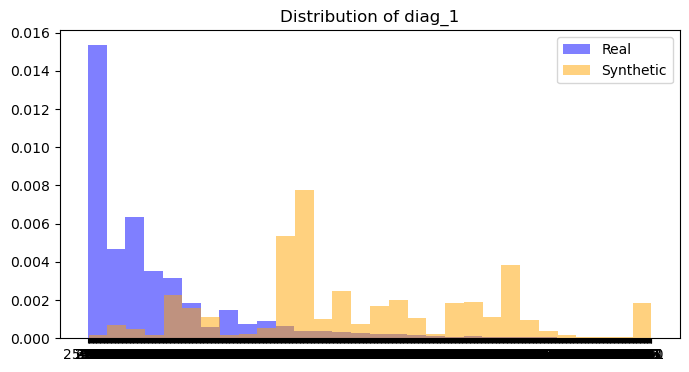

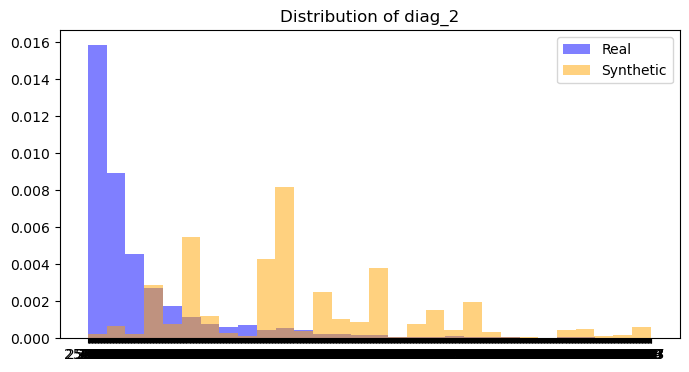

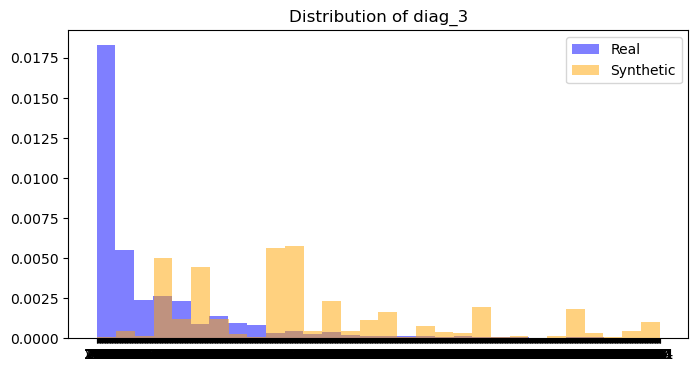

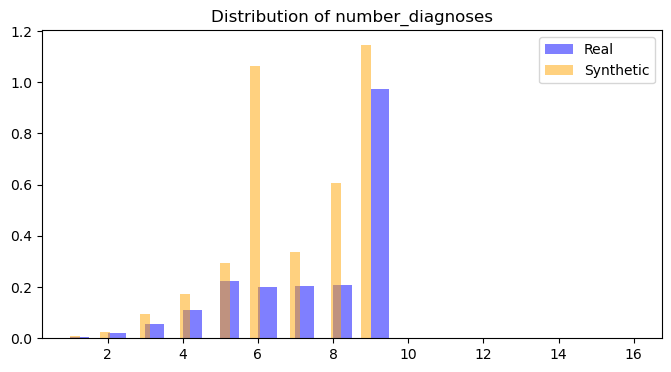

TypeError: 'value' must be an instance of str or bytes, not a float

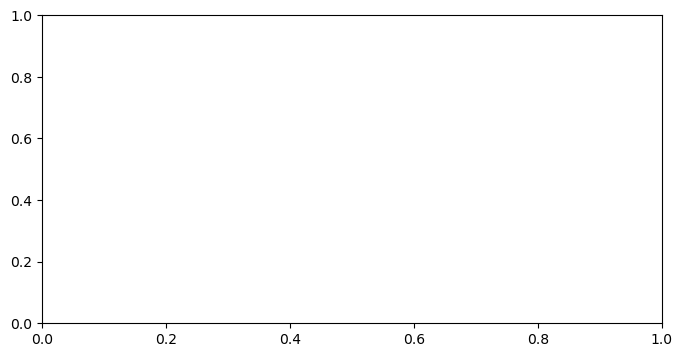

In [9]:
import matplotlib.pyplot as plt

numerical_columns = data.select_dtypes(include=["int64", "float64"]).columns

for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(original_data[col], bins=30, alpha=0.5, label='Real', color='blue', density=True)
    plt.hist(synthetic_data[col], bins=30, alpha=0.5, label='Synthetic', color='orange', density=True)
    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.show()


Skipping race due to insufficient valid data.
Skipping gender due to insufficient valid data.
Skipping age due to insufficient valid data.
Skipping weight due to insufficient valid data.


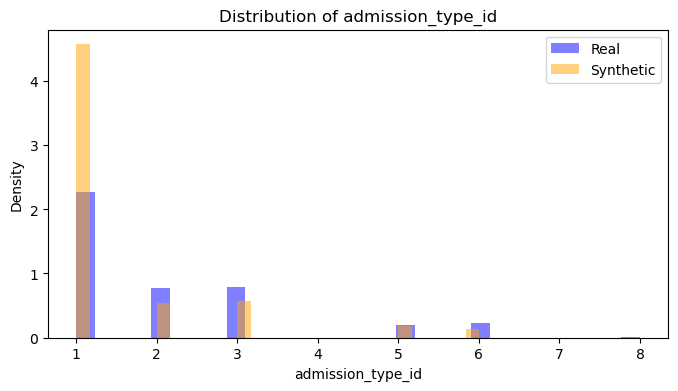

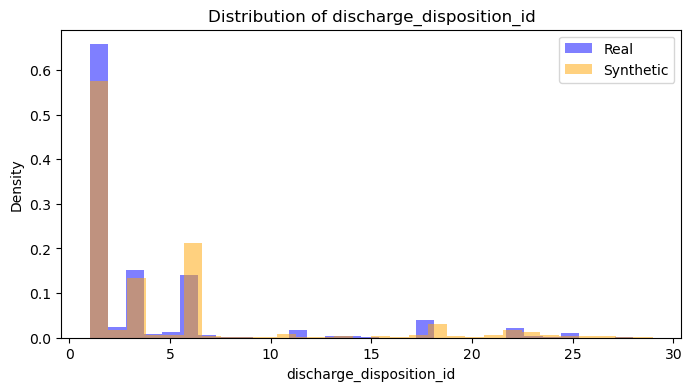

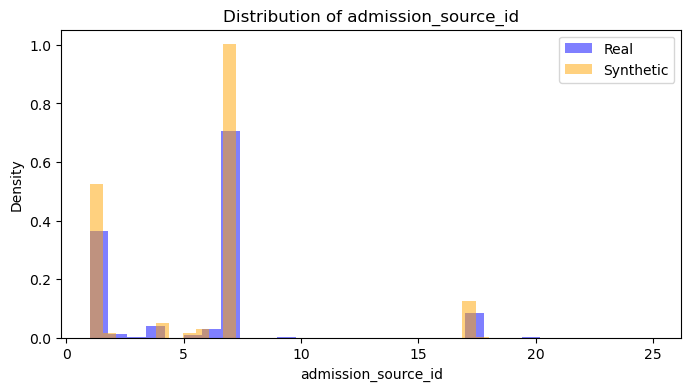

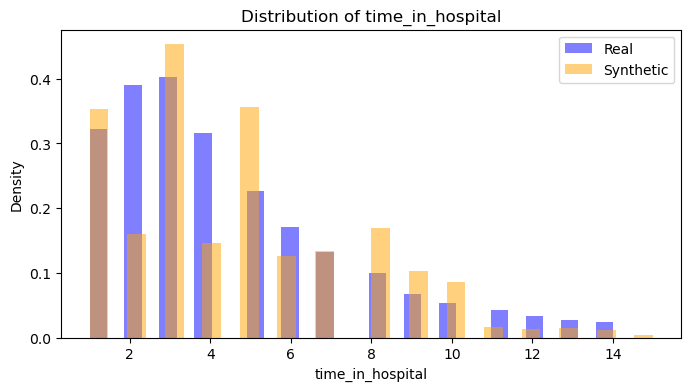

Skipping payer_code due to insufficient valid data.
Skipping medical_specialty due to insufficient valid data.


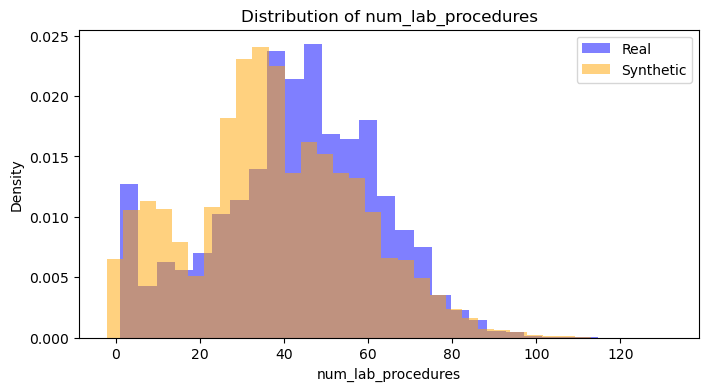

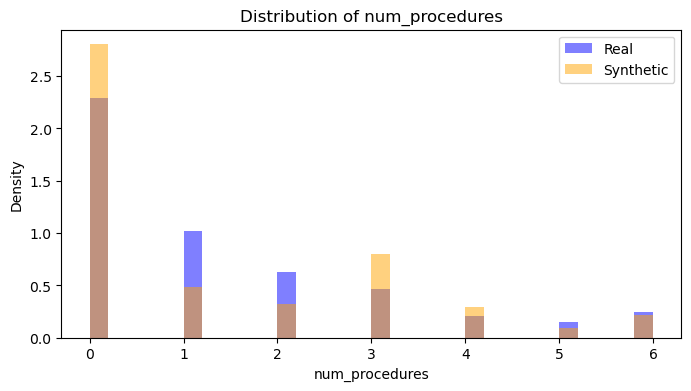

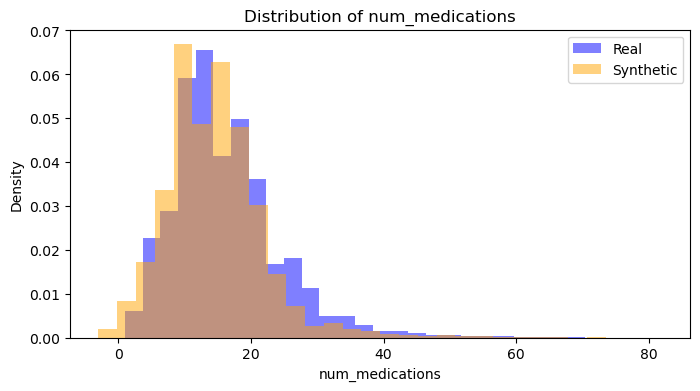

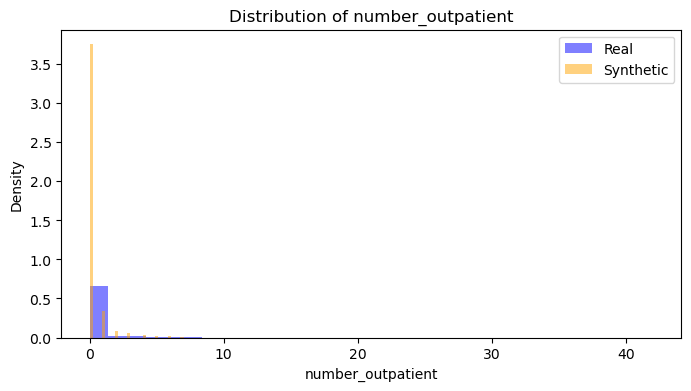

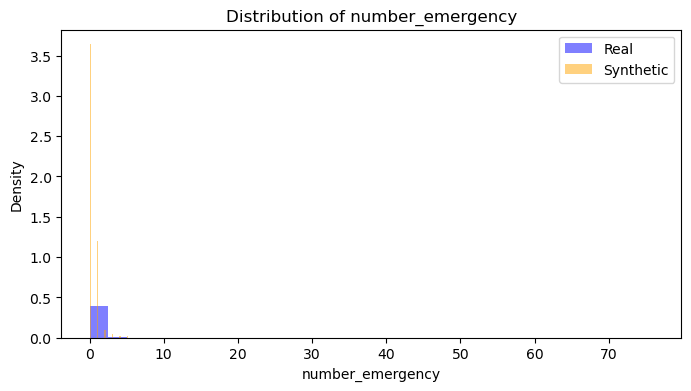

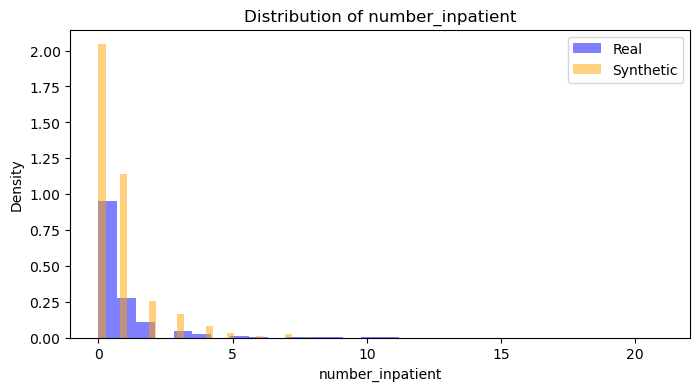

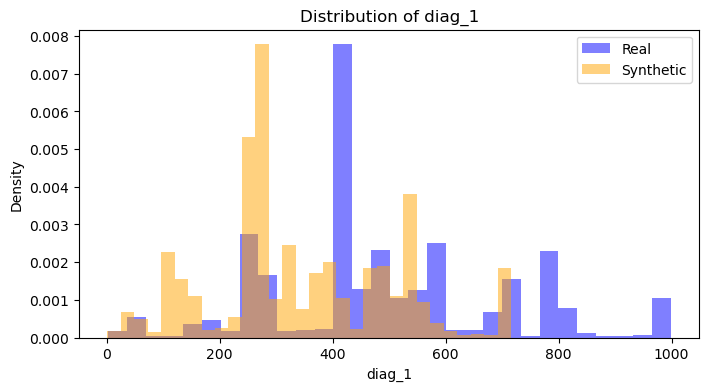

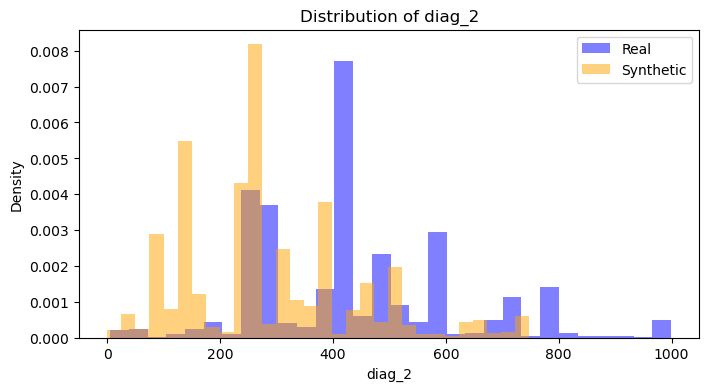

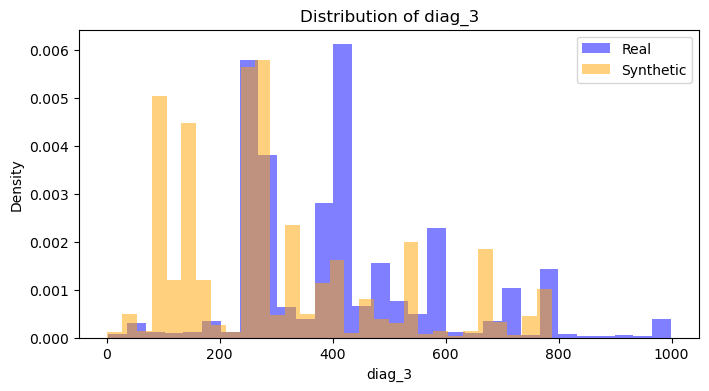

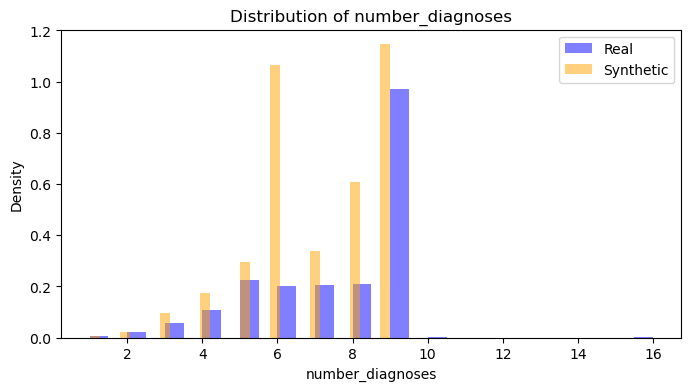

Skipping max_glu_serum due to insufficient valid data.
Skipping A1Cresult due to insufficient valid data.
Skipping metformin due to insufficient valid data.
Skipping repaglinide due to insufficient valid data.
Skipping nateglinide due to insufficient valid data.
Skipping chlorpropamide due to insufficient valid data.
Skipping glimepiride due to insufficient valid data.
Skipping acetohexamide due to insufficient valid data.
Skipping glipizide due to insufficient valid data.
Skipping glyburide due to insufficient valid data.
Skipping tolbutamide due to insufficient valid data.
Skipping pioglitazone due to insufficient valid data.
Skipping rosiglitazone due to insufficient valid data.
Skipping acarbose due to insufficient valid data.
Skipping miglitol due to insufficient valid data.
Skipping troglitazone due to insufficient valid data.
Skipping tolazamide due to insufficient valid data.
Skipping examide due to insufficient valid data.
Skipping citoglipton due to insufficient valid data.
S

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

numerical_columns = data.select_dtypes(include=["int64", "float64"]).columns

for col in numerical_columns:
    try:
        # Ensure numeric data and drop invalid values
        real_data = pd.to_numeric(original_data[col], errors='coerce').dropna()
        synthetic_data_col = pd.to_numeric(synthetic_data[col], errors='coerce').dropna()

        # Skip if either dataset becomes empty after cleaning
        if real_data.empty or synthetic_data_col.empty:
            print(f"Skipping {col} due to insufficient valid data.")
            continue

        # Create histogram comparison
        plt.figure(figsize=(8, 4))
        plt.hist(real_data, bins=30, alpha=0.5, label='Real', color='blue', density=True)
        plt.hist(synthetic_data_col, bins=30, alpha=0.5, label='Synthetic', color='orange', density=True)
        
        # Add titles and labels
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"Error processing column {col}: {e}")


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define target column
target_column = "readmitted"  # Replace with the correct target column

# Extract features and target
X_synthetic = synthetic_data.drop(columns=[target_column, "membership"])
y_synthetic = synthetic_data[target_column]
X_real = test_data.drop(columns=[target_column])
y_real = test_data[target_column]

# Train a Random Forest model on synthetic data
utility_model = RandomForestClassifier(random_state=42)
utility_model.fit(X_synthetic, y_synthetic)

# Test the model on real data
y_pred_utility = utility_model.predict(X_real)

# Evaluate performance
utility_results = {
    "accuracy": accuracy_score(y_real, y_pred_utility),
    "precision": precision_score(y_real, y_pred_utility, average="weighted"),
    "recall": recall_score(y_real, y_pred_utility, average="weighted"),
    "f1_score": f1_score(y_real, y_pred_utility, average="weighted")
}
print("Utility Results:", utility_results)


Utility Results: {'accuracy': 0.47759654122039896, 'precision': 0.43675038254342197, 'recall': 0.47759654122039896, 'f1_score': 0.4495281105010891}


In [15]:
from scipy.stats import ks_2samp

numerical_columns = data.select_dtypes(include=["int64", "float64"]).columns
fidelity_results = {}

for col in numerical_columns:
    real_data = test_data[col].dropna()
    synthetic_data_col = synthetic_data[col].dropna()
    stat, p_value = ks_2samp(real_data, synthetic_data_col)
    fidelity_results[col] = {"KS Statistic": stat, "P-Value": p_value}

print("Fidelity Results (KS Test):", fidelity_results)


Fidelity Results (KS Test): {'race': {'KS Statistic': 0.0980642625528152, 'P-Value': 1.2151666348854623e-85}, 'gender': {'KS Statistic': 0.21003242605876, 'P-Value': 0.0}, 'age': {'KS Statistic': 0.08578166453768293, 'P-Value': 1.3317230821229192e-65}, 'weight': {'KS Statistic': 0.016704333300579743, 'P-Value': 0.006753520078815049}, 'admission_type_id': {'KS Statistic': 0.23322197111132947, 'P-Value': 0.0}, 'discharge_disposition_id': {'KS Statistic': 0.0801807998427827, 'P-Value': 2.3329786555064414e-57}, 'admission_source_id': {'KS Statistic': 0.007173037240837177, 'P-Value': 0.6688627940889258}, 'time_in_hospital': {'KS Statistic': 0.10287904097474698, 'P-Value': 3.1073670961960095e-94}, 'payer_code': {'KS Statistic': 0.10366512724771537, 'P-Value': 1.1223201895153635e-95}, 'medical_specialty': {'KS Statistic': 0.11894467917853979, 'P-Value': 6.476862522633005e-126}, 'num_lab_procedures': {'KS Statistic': 0.1694998526088239, 'P-Value': 4.426123808546029e-256}, 'num_procedures': {'K

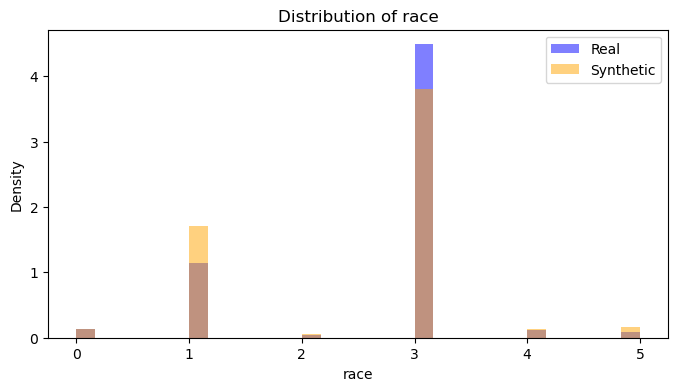

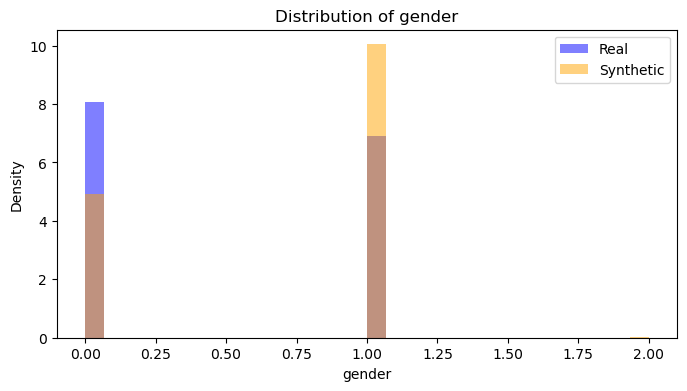

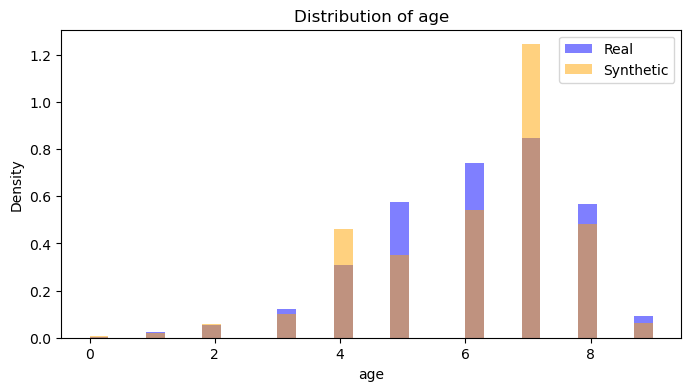

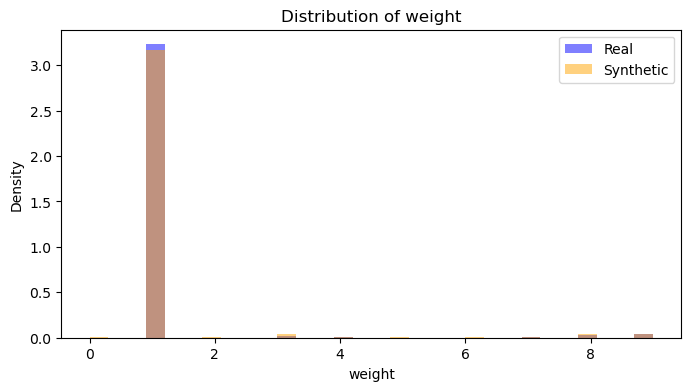

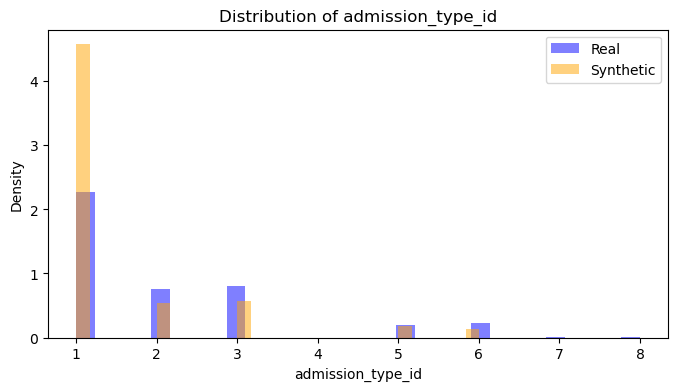

In [16]:
import matplotlib.pyplot as plt

for col in numerical_columns[:5]:  # Limit to the first 5 columns for simplicity
    plt.figure(figsize=(8, 4))
    plt.hist(test_data[col], bins=30, alpha=0.5, label='Real', color='blue', density=True)
    plt.hist(synthetic_data[col], bins=30, alpha=0.5, label='Synthetic', color='orange', density=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [17]:
real_corr = test_data.corr()
synthetic_corr = synthetic_data.corr()
correlation_diff = (real_corr - synthetic_corr).abs()

print("Average Correlation Difference:", correlation_diff.mean().mean())


Average Correlation Difference: 0.03527021277893228


Gen. (0.00) | Discrim. (0.00):   0%|          | 0/200 [00:00<?, ?it/s]


AssertionError: 